# Gibbs sampling on Ising model

In [1]:
"""
Author : Ming Liang Ang
Based on : https://github.com/probml/pmtk3/blob/master/demos/gibbsDemoIsing.m
"""

import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

# try:
#     import probml_utils as pml
# except ModuleNotFoundError:
#     %pip install -qq git+https://github.com/probml/probml-utils.git
#     import probml_utils as pml

In [2]:
n_pixels = 100
pixels = jnp.array(range(n_pixels))


def energy(ix, iy, X, J):
    wi = 0
    wi += jax.lax.cond(iy > 0, lambda: X[iy - 1, ix], lambda: 0)  # if iy != 0 then add X[iy - 1, ix]
    wi += jax.lax.cond(iy < n_pixels - 1, lambda: X[iy + 1, ix], lambda: 0)
    wi += jax.lax.cond(ix > 0, lambda: X[iy, ix - 1], lambda: 0)
    wi += jax.lax.cond(ix < n_pixels - 1, lambda: X[iy, ix + 1], lambda: 0)
    return 2 * J * wi


def gibbs_samples(rng_key, J, niter):

    x_values = jnp.array([-1, 1])  # x is binary variable having values either -1 or +1
    grid = jnp.array(jax.random.choice(rng_key, a=x_values, shape=(n_pixels, n_pixels)))  # create grid

    @jax.jit
    def one_step(grid, key):
        keys = jax.random.split(key)
        ix = jnp.array(jax.random.choice(keys[0], a=pixels))  # pick random x pixel
        iy = jax.random.choice(keys[1], a=pixels)  # pick random y pixel
        e = energy(ix, iy, grid, J)  # calculate enerygy on (ix, iy)
        p_ix_iy = jax.nn.sigmoid(e)  # probability
        u = jax.random.uniform(key)
        grid = grid.at[iy, ix].set(jax.lax.cond(u < p_ix_iy, lambda: 1, lambda: -1))
        return grid, None

    keys = jax.random.split(key=rng_key, num=niter)
    grid, _ = jax.lax.scan(one_step, grid, keys)
    return grid

In [3]:
niter = 50000
gibbs_samples_jit = jax.jit(gibbs_samples, static_argnames=["niter"])

In [ ]:
#pml.latexify(width_scale_factor=3, fig_height=1.5)

/home/patel_zeel/Probml_karm/probml-utils/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


In [4]:
def plot_samples(J, sample_grid, fig_no=None):
    cords = jnp.array(range(len(sample_grid)))
    x, y = jnp.meshgrid(cords, cords)
    plt.figure()
    plt.pcolormesh(x, y, sample_grid, cmap="Greys")
    plt.gca().set_aspect("equal")
    plt.title(f"$J={J}$")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.xticks(range(0, 101, 50))
    plt.yticks(range(0, 101, 50))
    # if fig_no != None:
    #     pml.savefig("gibbsDemoIsing{}.pdf".format(fig_no))

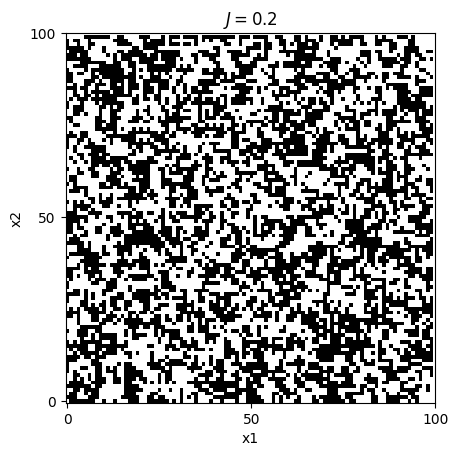

In [5]:
J = 0.2  # J is coupling strength between two nodes (here two pixels)
sample_grid = gibbs_samples_jit(jax.random.PRNGKey(0), J, niter)
plot_samples(J, sample_grid, 0)

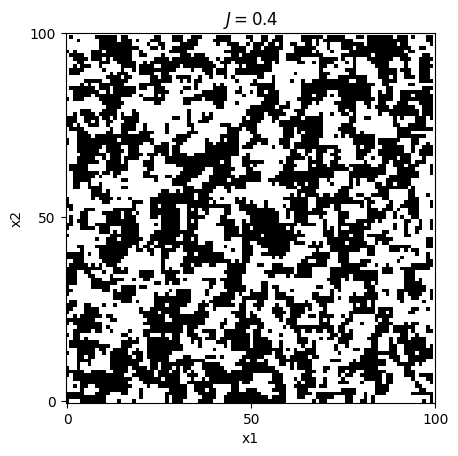

In [13]:
J = 0.4
sample_grid = gibbs_samples_jit(jax.random.PRNGKey(1), J, niter)
plot_samples(J, sample_grid, 1)

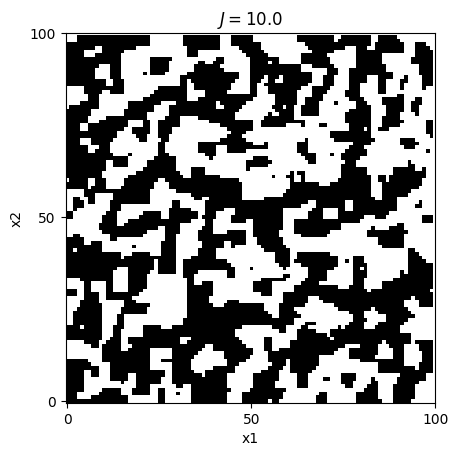

In [14]:
J = 10.
sample_grid = gibbs_samples_jit(jax.random.PRNGKey(2), J, niter)
plot_samples(J, sample_grid, 2)

In [9]:
from ipywidgets import interact


@interact(J=(0.1, 50, 0.5))
def generate_random(J):
    n_iter = 50000
    grid = gibbs_samples_jit(jax.random.PRNGKey(0), J, n_iter)
    plot_samples(J, grid)

interactive(children=(FloatSlider(value=24.6, description='J', max=50.0, min=0.1, step=0.5), Output()), _dom_c…